# Sentiment Analysis of Amazon Appliances

Dataset: <link>https://amazon-reviews-2023.github.io/#for-user-reviews</link>

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
from transformers import pipeline

import seaborn as sns
import matplotlib.pyplot as plt

## Loading the Dataset

In [12]:
# Load user reviews - 100,000 only
user_reviews = pd.read_json("data/Appliances.jsonl", lines=True, nrows=10000)
user_reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Work great,work great. use a new one every month,[],B01N0TQ0OH,B01N0TQ0OH,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2018-02-22 16:31:48.692,0,True
1,5,excellent product,Little on the thin side,[],B07DD2DMXB,B07DD37QPZ,AHWWLSPCJMALVHDDVSUGICL6RUCA,2022-10-02 21:41:03.446,0,True
2,5,Happy customer!,"Quick delivery, fixed the issue!",[],B082W3Z9YK,B082W3Z9YK,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,2020-12-06 03:30:35.363,0,True
3,5,Amazing value,I wasn't sure whether these were worth it or n...,[],B078W2BJY8,B078W2BJY8,AFGUPTDFAWOHHL4LZDV27ERDNOYQ,2018-08-12 20:03:04.306,0,True
4,5,Dryer parts,Easy to install got the product expected to re...,[],B08C9LPCQV,B08C9LPCQV,AELFJFAXQERUSMTXJQ6SYFFRDWMA,2021-05-05 01:03:23.754,0,True


In [13]:
print(user_reviews.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             10000 non-null  int64         
 1   title              10000 non-null  object        
 2   text               10000 non-null  object        
 3   images             10000 non-null  object        
 4   asin               10000 non-null  object        
 5   parent_asin        10000 non-null  object        
 6   user_id            10000 non-null  object        
 7   timestamp          10000 non-null  datetime64[ns]
 8   helpful_vote       10000 non-null  int64         
 9   verified_purchase  10000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 713.0+ KB
None


In [14]:
user_reviews.size

100000

## Data Preprocessing

In [15]:
# Check for empty rows
print(user_reviews.isnull().sum())

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

user_reviews['cleaned_review'] = user_reviews['text'].apply(preprocess_text)

In [18]:
print(user_reviews['cleaned_review'].head())

0                   work great use new one every month
1                                     little thin side
2                           quick delivery fixed issue
3    wasnt sure whether worth given cost compared o...
4            easy install got product expected receive
Name: cleaned_review, dtype: object


## Sentiment Analysis

In [19]:
analyser = pipeline("sentiment-analysis", truncation=True, max_length=512)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [20]:
batch_size = 32

# Process in batches
def process_batches(user_reviews):
    sentiments = []
    for i in range(0, len(user_reviews), batch_size):
        batch_reviews = user_reviews['cleaned_review'].iloc[i:i + batch_size].tolist()
        try:
            batch_sentiments = analyser(batch_reviews)
            sentiments.extend([sentiment['label'] for sentiment in batch_sentiments])
        except Exception as e:
            print(f"Error processing batch starting at index {i}: {str(e)}")
            # For any failed reviews, mark as 'UNKNOWN'
            sentiments.extend(['UNKNOWN'] * len(batch_reviews))
    return sentiments



In [21]:
user_reviews['sentiment'] = process_batches(user_reviews)

In [22]:
print("Sample of processed reviews:")
print(user_reviews[['cleaned_review', 'sentiment']].head())

Sample of processed reviews:
                                      cleaned_review sentiment
0                 work great use new one every month  POSITIVE
1                                   little thin side  NEGATIVE
2                         quick delivery fixed issue  NEGATIVE
3  wasnt sure whether worth given cost compared o...  NEGATIVE
4          easy install got product expected receive  NEGATIVE


In [23]:

# Print some statistics
print("\nSentiment Distribution:")
print(user_reviews['sentiment'].value_counts())


Sentiment Distribution:
sentiment
NEGATIVE    5235
POSITIVE    4765
Name: count, dtype: int64


## Results

/Users/alex/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alex/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alex/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Count')

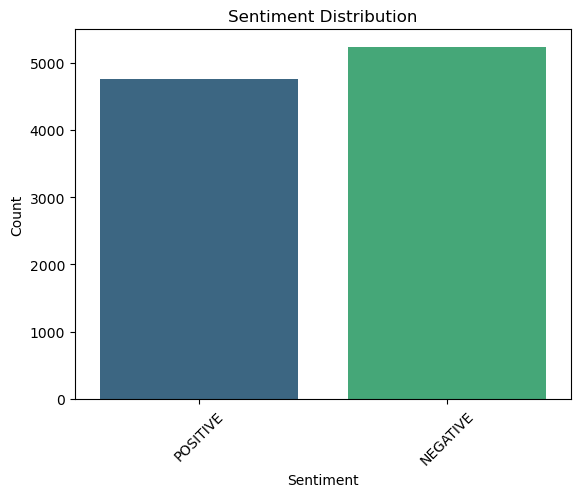

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=user_reviews, x='sentiment', palette='viridis')
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.xlabel('Sentiment')
plt.ylabel('Count')
